In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier, plot_tree
from ipywidgets import interact, interactive, fixed, interact_manual
import plotly.express as px


In [4]:
# @Arguments: filename
# @Returns: dataframe
def _get_data(fileName):
    return (pd.read_csv(fileName))

# @Arguments: Takes numerical and categorical featuers(onehot)
# @Returns: final features list
def _make_features(num_feats, cat_feats):
    num_feats = np.array(num_feats.values)
    finalFeats = np.hstack((num_feats, cat_feats))
    return (finalFeats)


# @Arguments: array of categorical data
# @Returns: one hot data representations
def _get_onehot(data):
    onehot = OneHotEncoder(sparse=False)
    one_hotData = onehot.fit_transform(data)
    return (one_hotData)

# @Arguments: filename
# @Returns: df and features(with one hot representations)
def make_data(fileName):
    df = _get_data(fileName)
    num_features = df[[
        'MPG', 'Horsepower', 'Cylinders', 'Displacement', 'Weight',
        'Acceleration', 'Year'
    ]]
    cat_data = df['Origin']
    cat_features = _get_onehot(cat_data.values.reshape(-1, 1))

    features = _make_features(num_features, cat_features)
    return (df, features)

In [5]:
PATH = "../Data/cars.csv"

In [6]:
dfData, features = make_data(PATH)

In [7]:
@interact(feature = dfData.columns)
def vis_histogram(feature):
  vis = px.histogram(dfData, feature)
  vis.show()

interactive(children=(Dropdown(description='feature', options=('Model', 'MPG', 'Cylinders', 'Displacement', 'H…

In [8]:
# There are multiple versions of the same car, that's interesting!
dfData[dfData["Model"]=="ford pinto"]

,Model,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin
111,ford pinto,19.0,4,122.0,85,2310,18.5,73,US
128,ford pinto,26.0,4,122.0,80,2451,16.5,74,US
166,ford pinto,23.0,4,140.0,83,2639,17.0,75,US
172,ford pinto,18.0,6,171.0,97,2984,14.5,75,US
204,ford pinto,26.5,4,140.0,72,2565,13.6,76,US


In [9]:
onehot = OneHotEncoder()
onehot.fit_transform(np.array(dfData["Origin"]).reshape(-1,1))
onehot.categories_

[array(['Europe', 'Japan', 'US'], dtype=object)]

In [10]:
feature_indices = [0,1,2,5]
onehot_cats = ['Europe', 'Japan', 'USA']

pipe = make_pipeline(RobustScaler(), TSNE(random_state=10))
feats = pipe.fit_transform(features[:,feature_indices])
clustering = KMeans(n_clusters = 3)

clustering.fit(feats)
feats_color = clustering.labels_

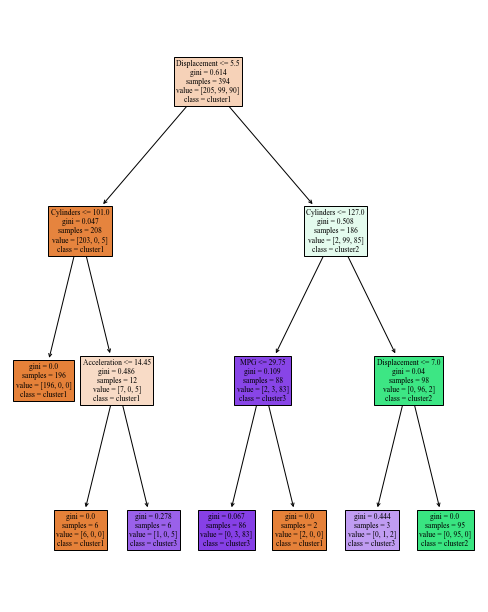

In [11]:

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(features[:,feature_indices], feats_color)
plt.figure(figsize=(8.5,11))
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 200

plot_tree(clf, filled=True, class_names=["cluster1","cluster2","cluster3"], feature_names= [dfData.columns[f+1] if f<7 else onehot_cats[f-7] for f in feature_indices])
plt.savefig("../plots/dt.png")
plt.show()
%matplotlib inline

In [12]:
classificationScore = clf.score(features[:,feature_indices], feats_color)*100
print("The above decision tree uses the four features given as input to the clustering algorithm")
print("Classification score of Decision Tree Classifier : %.2f " % classificationScore)

The above decision tree uses the four features given as input to the clustering algorithm
Classification score of Decision Tree Classifier : 98.73 


In [13]:
print("Columns used in this analysis :")
dfData.columns[[f+1 for f in feature_indices]]

Columns used in this analysis :


Index(['MPG', 'Cylinders', 'Displacement', 'Acceleration'], dtype='object')

In [14]:
dfData.Year = [1900 + d for d in dfData.Year]

In [15]:
dfData["Model_Year"] = dfData["Model"].values + ", " + np.array([str(d) for d in dfData["Year"].values])

In [16]:
# Create and save the csv file
dfData['cluster'] = feats_color
dfData['dim1'] = feats[:,0]
dfData['dim2'] = feats[:,1]

In [17]:
dfData.to_csv("../Data/tsne_kmeans_0123_cars.csv")

In [20]:
from collections import Counter
Counter(pd.read_csv("../Data/tsne_kmeans_0123_cars.csv")["cluster"].values)

Counter({1: 99, 0: 205, 2: 90})